In [1]:
import os
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider

In [2]:
file_names = glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/*')

annotations = dict()

for file_name in tqdm(file_names):
    for i in [1,2]:
        try:
            annotations[f"{file_name.split('/')[-1][:-4]}"] = matplotlib.image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")  
            continue

        except FileNotFoundError as e:

            pass
            #print(f'{file_name} not found')

In [3]:
cubes = {file_name.split('/')[-1][:-4]: pd.read_hdf(file_name, key='Data') for file_name in file_names[1:2]}

In [4]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
master = pd.read_excel('Master.xlsx')

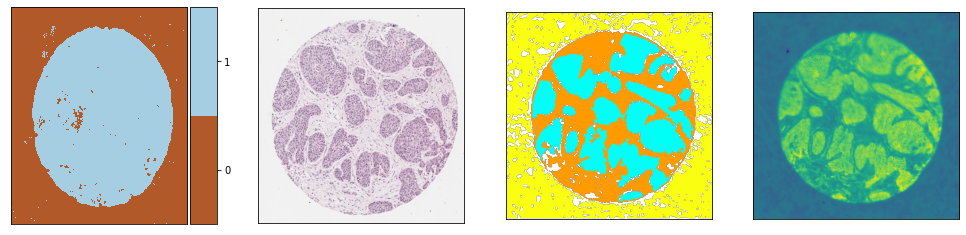

(256, 256)
Area: 1 	N clusters: 3


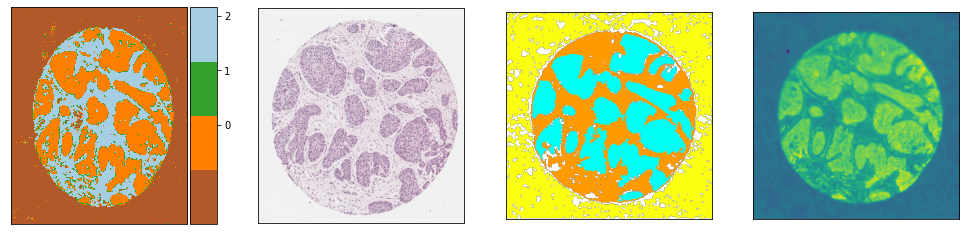

(256, 256)
Area: 0 	N clusters: 2


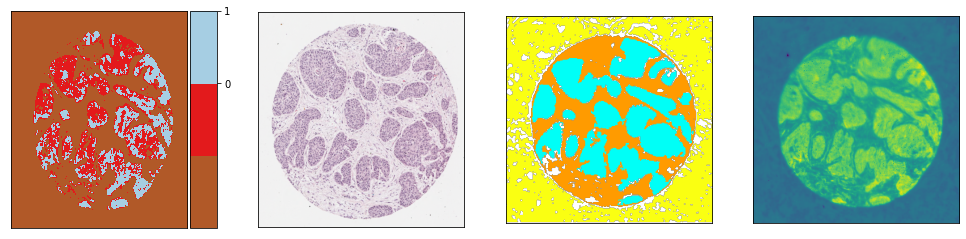

In [36]:
row = master.iloc[[1]]
idx = row.index[0]

ftir = pd.read_hdf(row['FTIR'][idx], key='Data')
ann = matplotlib.image.imread(row['ANNOTATION'][idx])
he = matplotlib.image.imread(row['HE'][idx])

ref = row['REF'][idx]

cluster_annotations([ftir, ann, he], 2, ref)



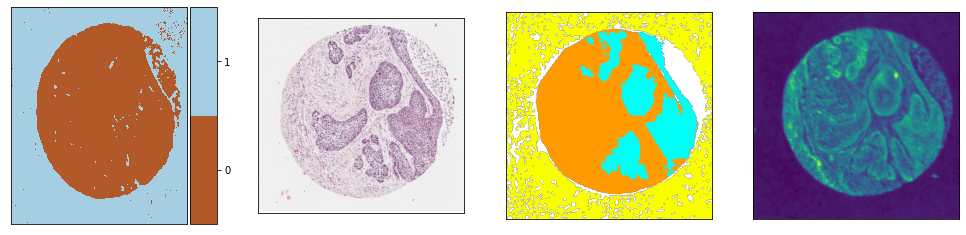

(256, 256)
Area: 0 	N clusters: 3


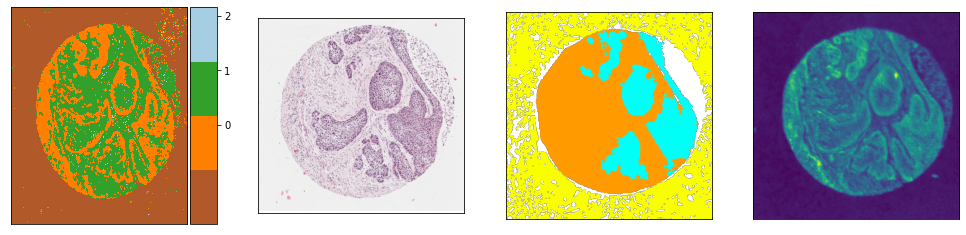

(256, 256)
Area: 0 	N clusters: 2


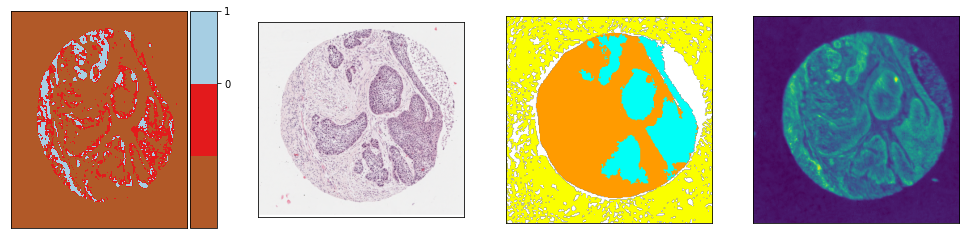

<ipython-input-26-59a17f32ee2d>:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask = (y.argmin(axis=1) == svsel)


AttributeError: 'bool' object has no attribute 'flatten'

In [37]:
row = master.iloc[[5]]
idx = row.index[0]

ftir = pd.read_hdf(row['FTIR'][idx], key='Data')
ann = matplotlib.image.imread(row['ANNOTATION'][idx])
he = matplotlib.image.imread(row['HE'][idx])

ref = row['REF'][idx]

cluster_annotations([ftir, ann, he], 2, ref)



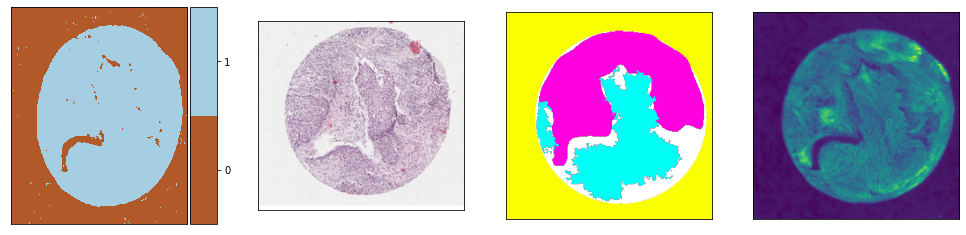

(256, 256)
Area: 1 	N clusters: 3


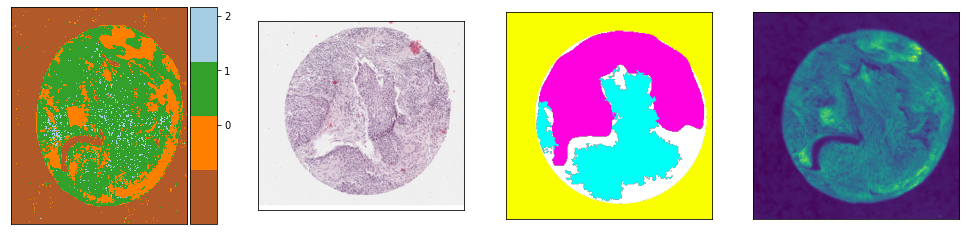

(256, 256)
Area: 1 	N clusters: 3


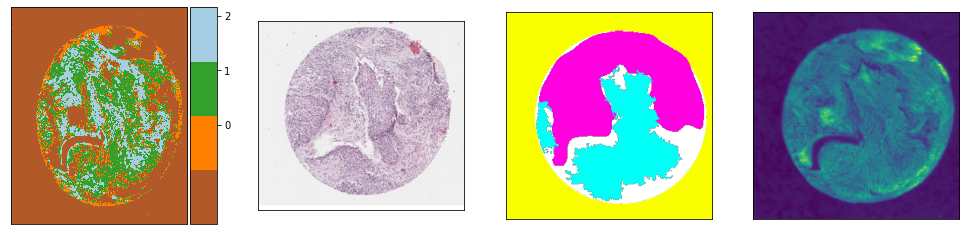

In [40]:
row = master.iloc[[7]]
idx = row.index[0]

ftir = pd.read_hdf(row['FTIR'][idx], key='Data')
ann = matplotlib.image.imread(row['ANNOTATION'][idx])
he = matplotlib.image.imread(row['HE'][idx])

ref = row['REF'][idx]

cluster_annotations([ftir, ann, he], 2, ref)



im = 'TMA_1.2_D10'
cdf = pd.read_hdf(f'/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/{im}.hdf', key='Data')
annotation = matplotlib.image.imread('/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/TMA_2_1/D10.png')
he = matplotlib.image.imread('/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/TMA_2_1/D10.png')

km = KMeans().fit_transform(cdf).argmin(axis=1).reshape(256,256)

axim = plt.imshow(km, cmap = matplotlib.cm.get_cmap('Paired_r', 8))

In [34]:
def cluster_annotations(images, nk, ref, imsize=4, mask=None):

    fig, axes = plt.subplots(ncols=4, figsize=(20,6))
    [ax.set_xticks([]) for ax in axes]
    [ax.set_yticks([]) for ax in axes]

    cubedf, ann, he = images

    # Amide slice which to overwrite with new annotation
    cube_s = cubedf.values.reshape(256,256,-1)[:,:,195]
    pipe = Pipeline([('Scaler', StandardScaler()),('Cluster', KMeans(nk, random_state=1))])

    if mask is None:

        y = pipe.fit_transform(images[0])
        im_km = y.argmin(axis=1).reshape(256,256)

        nc = 2'
        cr = np.arange(nc)

    else:

        y = pipe.fit_transform(images[0].values[mask.flatten()])
        im_km = cube_s.copy().flatten()
        im_km[mask.flatten()] = y.argmin(axis=1)
        im_km[~mask.flatten()] = -1
        im_km = im_km.reshape(256,256)

        nc = nk+1
        cr = np.arange(-1, nc)


    axim = axes[0].imshow(im_km, cmap = matplotlib.cm.get_cmap('Paired_r', nc), aspect='auto',interpolation=None)
    divider = make_axes_locatable(axes[0])
    cax  = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(axim, cax=cax)
    tick_locs = (np.arange(nc) + 0.5)*(nc-1)/nc
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels()

    axes[1].set_aspect('equal')
    axes[1].imshow(he)
    axes[2].imshow(ann)
    axes[3].imshow(cube_s)
    plt.show()

    sv = input("Save? (y/n)").lower()

    if sv == 'n':
        
        sel = int(input("Select which area?"))
        nk = int(input("How many clusters?"))
        
        #mask = np.where(y.argmin(axis=1) == sel)[0]
        mask = (y.argmin(axis=1) == sel)
        mask = (axim._A==sel)
        print(mask.shape)

        print(f'Area: {sel} \tN clusters: {nk}')

        cluster_annotations(images, nk, ref, mask=mask)

    else:

        svsel = np.array([int(area) for area in input("Select which area(s)?").split(',')])
        mask = (y.argmin(axis=1) == svsel)
        mask = (axim._A == svsel)

        output = images[0].iloc[mask.flatten(),:]

        dir = f'./ADV_front_Outputs/{ref}'

        try:
            os.mkdir(dir)
        except:
            pass
        output.to_hdf(dir + f'/{ref}.hdf', key='Data')

        plt.imsave(dir + f'/{ref}_mask.png', mask)


SyntaxError: EOL while scanning string literal (<ipython-input-34-dc5e4a8399d9>, line 18)

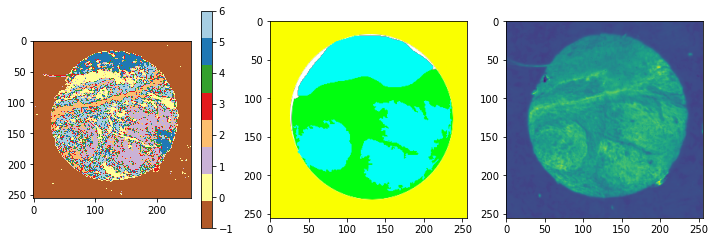

In [45]:
yw = 0
nk = 7

km = Pipeline([('Scaler', StandardScaler()),('Cluster', KMeans(nk))])
y_2 = km.fit_transform(cube[y.argmin(axis=1)==yw])

cube_2 = cube.copy().mean(axis=1).values
cube_2[np.where(y.argmin(axis=1)==yw)[0]] = y_2.argmin(axis=1)
cube_2[np.where(y.argmin(axis=1)!=yw)[0]] = -1

fig, axes = plt.subplots(ncols=3, figsize=(12,4))
ax=axes[0].imshow(cube_2.reshape(256,256), cmap= matplotlib.cm.get_cmap('Paired_r', nk+1))
plt.colorbar(ax, ax=axes[0])
axes[1].imshow(annotations[im])
#
axes[2].imshow(cube.values.reshape(256,256,-1)[:,:,195])

In [10]:
y = KMeans(3).fit_transform(ftir)

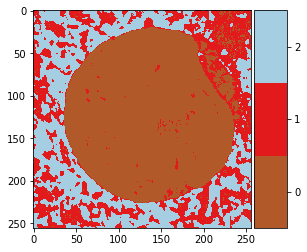

In [20]:
fig, ax = plt.subplots()

axim = ax.imshow(y.argmin(axis=1).reshape(256,256), cmap = matplotlib.cm.get_cmap('Paired_r', 3))
divider = make_axes_locatable(ax)
cax  = divider.append_axes("right", size="15%", pad=0.05)
cbar = plt.colorbar(axim, cax=cax)
tick_locs = (np.arange(3) + 0.5)*(3-1)/3
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(3))

In [17]:
vars(cbar)

{'mappable': <matplotlib.image.AxesImage at 0x7fb0328905b0>,
 'ax': <matplotlib.axes._axes.Axes at 0x7fb032369760>,
 'alpha': None,
 'cmap': <matplotlib.colors.ListedColormap at 0x7fb032c0a910>,
 'norm': <matplotlib.colors.Normalize at 0x7fb032378700>,
 'values': None,
 'boundaries': None,
 'extend': 'neither',
 '_inside': slice(0, None, None),
 'spacing': 'uniform',
 'orientation': 'vertical',
 'drawedges': False,
 'filled': True,
 'extendfrac': None,
 'extendrect': False,
 'solids': <matplotlib.collections.QuadMesh at 0x7fb0320ef2b0>,
 'lines': [],
 'outline': <matplotlib.patches.Polygon at 0x7fb0320e7c40>,
 'patch': <matplotlib.patches.Polygon at 0x7fb0320e7f40>,
 'dividers': None,
 'locator': <matplotlib.colorbar._ColorbarAutoLocator at 0x7fb0320e7e50>,
 'formatter': <matplotlib.ticker.ScalarFormatter at 0x7fb032c6ce20>,
 '_manual_tick_data_values': None,
 '_ColorbarBase__scale': 'linear',
 'ticklocation': 'right',
 '_label': '',
 '_labelkw': {},
 'stale': True,
 '_boundaries': arr